In [2]:
# NeuroDSP
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
# FOOOF
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
# Other
from scipy.io import loadmat
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
import matplotlib.pyplot as plt

<ipython-input-2-bfd378c9eea6>:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [3]:
# load mat file
data = loadmat('data/HPC_100_CH18_0.continuous.mat')
# print(data['HPC'])
hpc_data = data['HPC']
print("total amount of points:",len(hpc_data))

total amount of points: 27009195


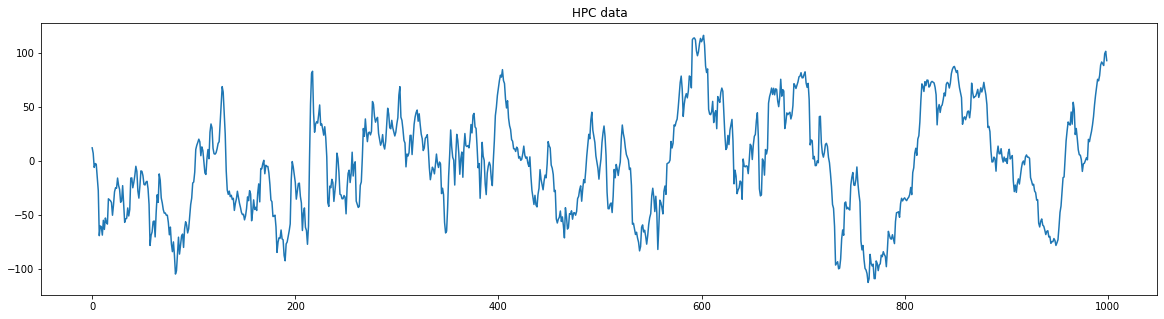

In [98]:
# plot data
plt.figure(figsize=(20, 5))
# x-axis in time untill 1000
range = np.arange(0, 1000)

# y-axis in data untill 1000
plt.plot(range, hpc_data[0:1000])
plt.title('HPC data')
plt.show()


np.mean and np.nanmean are both functions provided by the numpy library in Python to calculate the mean (average) of an array. The key difference between them lies in how they handle the 'NaN' (Not a Number) values.

np.mean(data): This function calculates the mean of the array 'data'. If the array contains 'NaN' values, the function will return 'NaN' as the mean.

np.nanmean(data): This function calculates the mean of the array 'data', ignoring any 'NaN' values. This is useful when you want to compute the mean of an array that contains 'NaN' values, and you want to treat them as missing values rather than as contributing to the mean.

In [102]:
# nomalize data
def normalize(data):
    return (data - np.nanmean(data)) / np.nanstd(data)
hpc_norm = normalize(hpc_data)

# flatten data
hpc_norm = hpc_norm.flatten()
fs = 2500 # sampling frequency
time = create_times(len(hpc_norm)/fs, fs)

# extract power spectrum
nperseg = min(2500, len(hpc_norm))
freqs, powers = compute_spectrum(hpc_norm[:7500], fs, method='welch', nperseg=nperseg)


Z-scoring, also known as standardization, is a statistical technique used to standardize data points in a dataset around the mean. This process gives your data zero mean and unit variance.




A power spectrum is a representation of a signal or function in the frequency domain. It describes the distribution of power into frequency components composing that signal. 

In the context of signal processing, the power spectrum of a time series describes the distribution of power (variance) over frequency. It is obtained by applying a Fourier transform to a time series data, squaring the absolute value of the result, and plotting it.

The power spectrum is a useful tool for identifying periodic components in a time series data. For example, if a time series data has a strong annual cycle, its power spectrum will show a peak at the frequency corresponding to one year.

In Python, you can use the `scipy.signal.periodogram` or `scipy.signal.welch` functions to compute the power spectrum of a time series.

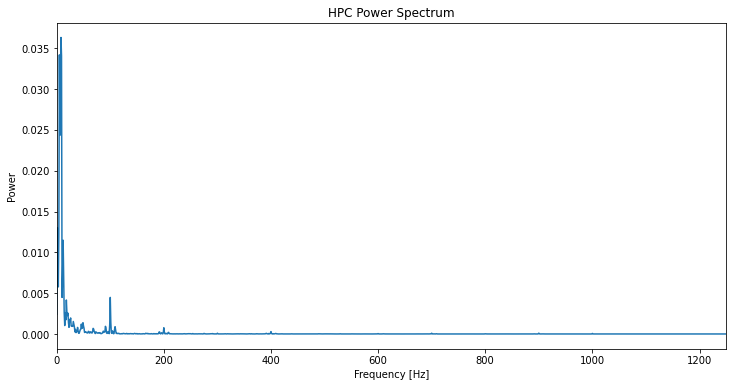

In [103]:
# plot power spectrum
plt.figure(figsize=(12, 6))
plt.plot(freqs, powers)
plt.title('HPC Power Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.xlim(0, fs/2)
plt.show()

In [25]:
sleep_scoring = loadmat('data/2021-06-03_13-34-04_posttrial5-states_ES2.mat')
sleep_scoring = sleep_scoring['states']
print(sleep_scoring.size)

10803


In [52]:
data_hpc = hpc_norm
data_HPC_30_min = data_hpc[:30*60*fs]
window_length = 3 * fs
aperiodic_params_HPC = []
freq_range = [1, 100]

for start in np.arange(0, len(data_HPC_30_min) - window_length + 1, window_length):
    window = data_HPC_30_min[start:start + window_length]
    window = np.ravel(window)
    freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)
    fm = FOOOF()
    fm.fit(freq_mean, psd_mean, freq_range)
    aperiodic_params_HPC.append(fm.get_params('aperiodic_params'))

In [112]:
print(aperiodic_params_HPC[0])


[-1.73084307  1.36889403]


-1.7308430722478934
600


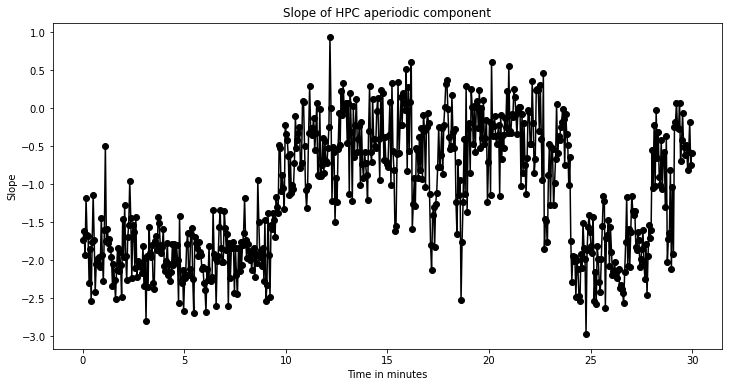

In [113]:
# get the slope of the aperiodic component
slopes = [param[0] for param in aperiodic_params_HPC]
print(slopes[0])
print(len(aperiodic_params_HPC))
# time
time = np.arange(1.5, 1.5 + 3 * len(aperiodic_params_HPC), 3)
time_minutes = time / 60

# plot the slope
plt.figure(figsize=(12, 6))
plt.plot(time_minutes, slopes, marker='o', color='black')
plt.title('Slope of HPC aperiodic component')
plt.xlabel('Time in minutes')
plt.ylabel('Slope')
plt.show()

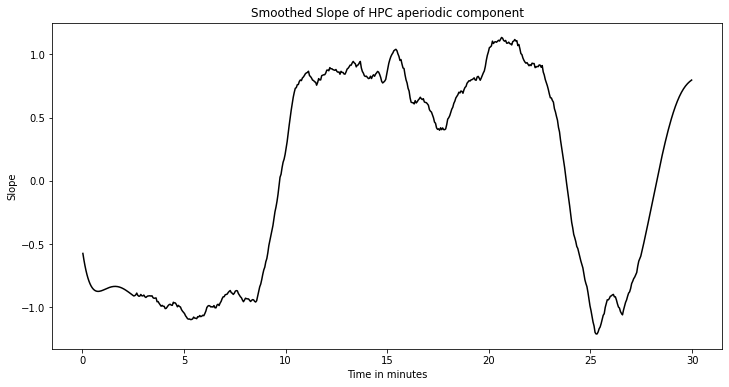

In [91]:
# nomralize the slope
slopes_norm = zscore(slopes)
# smooth the slope
slopes_smooth = savgol_filter(slopes_norm, window_length=101, polyorder=5)

# plot the smoothed slope
plt.figure(figsize=(12, 6))
plt.plot(time_minutes, slopes_smooth, color='black')
plt.title('Smoothed Slope of HPC aperiodic component')
plt.xlabel('Time in minutes')
plt.ylabel('Slope')
plt.show()

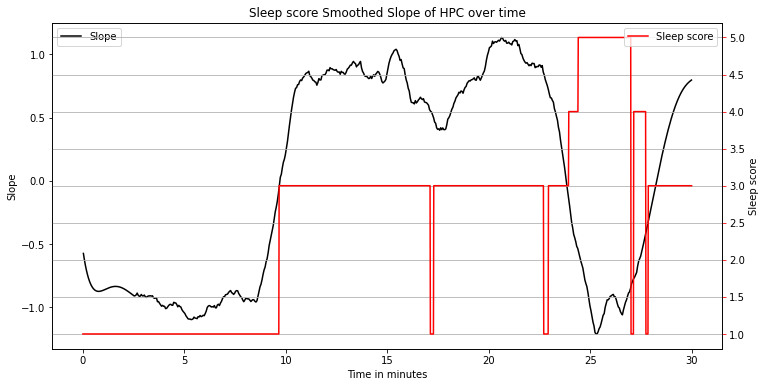

In [90]:
sleep_time = np.arange(0, 60, 1/60)
sleep_scoring_30_min = sleep_scoring[0][0:1800]
sleep_time = sleep_time[:len(sleep_scoring_30_min)].reshape(-1)

# plot the sleep scores over the smoothed slope
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(time_minutes, slopes_smooth, color='black', label='Slope')
ax1.set_xlabel('Time in minutes')
ax1.set_ylabel('Slope')
ax1.tick_params(axis='y', color='black')
ax1.legend(['Slope'], loc='upper left')
ax2 = ax1.twinx()
ax2.plot(sleep_time, sleep_scoring_30_min, color='red', label='Sleep score')
ax2.set_ylabel('Sleep score')
ax2.tick_params(axis='y', color='red')
ax2.legend(['Sleep score'], loc='upper right')

plt.title('Sleep score Smoothed Slope of HPC over time')
plt.grid(True)
plt.show()



In [95]:
# load mat file
pfc_data = loadmat('data/PFC_100_CH22_0.continuous.mat')
pfc_data = pfc_data['PFC']
print("total amount of points:",len(pfc_data))


total amount of points: 27009195


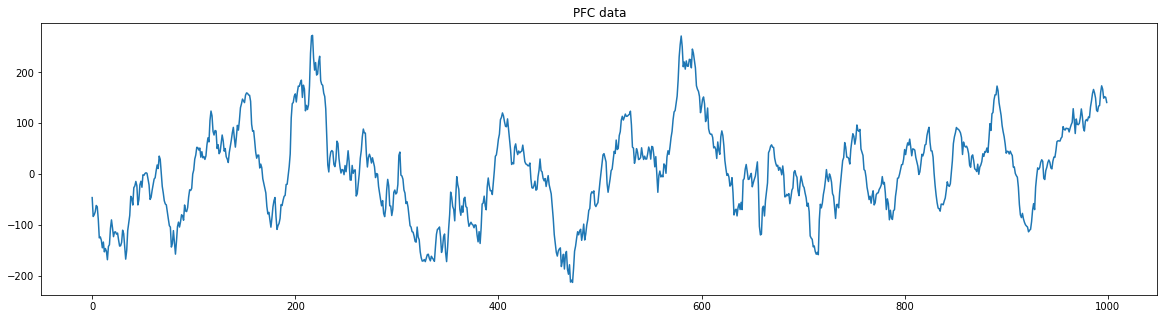

In [97]:
# plot the first 1000 points
plt.figure(figsize=(20, 5))
# x-axis in time untill 1000
range = np.arange(0, 1000)
# y-axis in data untill 1000
plt.plot(range, pfc_data[0:1000])
plt.title('PFC data')
plt.show()

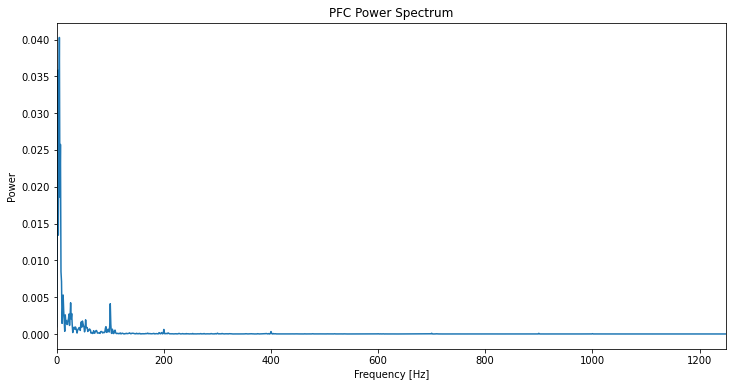

In [104]:
# nomalise pfc data
pfc_norm = normalize(pfc_data)

# flatten data
pfc_norm = pfc_norm.flatten()
fs = 2500 # sampling frequency

# extract power spectrum
nperseg = min(2500, len(pfc_norm))
freqs, powers = compute_spectrum(pfc_norm[:7500], fs, method='welch', nperseg=nperseg)

# plot power spectrum
plt.figure(figsize=(12, 6))
plt.plot(freqs, powers)
plt.title('Power Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.xlim(0, fs/2)
plt.title('PFC Power Spectrum')
plt.show()

In [105]:
pfc_data = pfc_norm
data_PFC_30_min = pfc_data[:30*60*fs]
window_length = 3 * fs
aperiodic_params_PFC = []
freq_range = [1, 100]

for start in np.arange(0, len(data_PFC_30_min) - window_length + 1, window_length):
    window = data_PFC_30_min[start:start + window_length]
    window = np.ravel(window)
    freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)
    fm = FOOOF()
    fm.fit(freq_mean, psd_mean, freq_range)
    aperiodic_params_PFC.append(fm.get_params('aperiodic_params'))

-1.8025099146714045
600


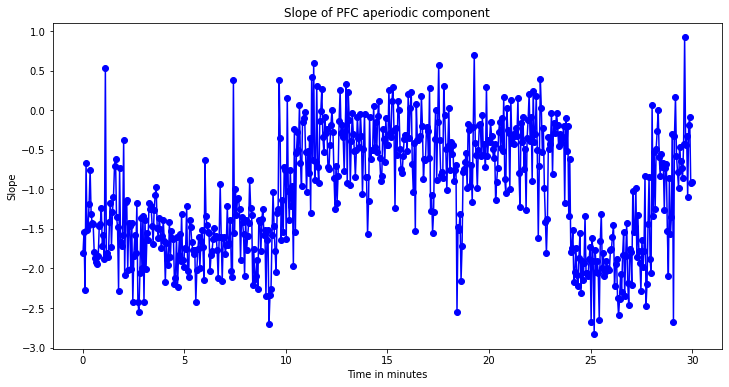

In [116]:
# get the slope of the aperiodic component
pfc_slopes = [param[0] for param in aperiodic_params_PFC]
print(pfc_slopes[0])
print(len(aperiodic_params_PFC))

# time
time = np.arange(1.5, 1.5 + 3 * len(aperiodic_params_PFC), 3)
time_minutes = time / 60

# plot the pfc slope
plt.figure(figsize=(12, 6))
plt.plot(time_minutes, pfc_slopes, marker='o', color='blue')
plt.title('Slope of PFC aperiodic component')
plt.xlabel('Time in minutes')
plt.ylabel('Slope')
plt.show()

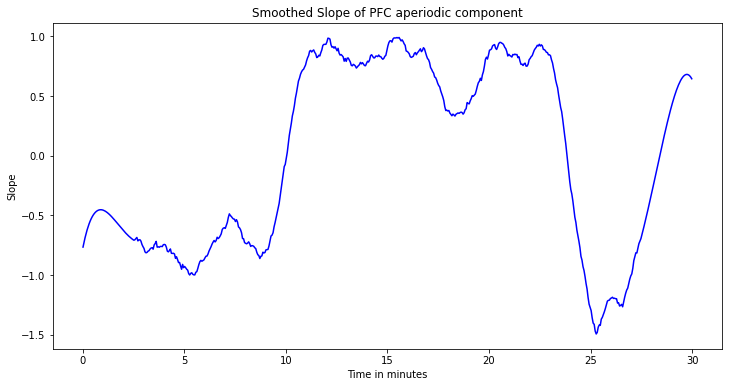

In [117]:
# smoothed pfc slopes
pfc_slopes_norm = zscore(pfc_slopes)
pfc_slopes_smooth = savgol_filter(pfc_slopes_norm, window_length=101, polyorder=4) # copied these from Amir

# plot the smoothed slope
plt.figure(figsize=(12, 6))
plt.plot(time_minutes, pfc_slopes_smooth, color='blue')
plt.title('Smoothed Slope of PFC aperiodic component')
plt.xlabel('Time in minutes')
plt.ylabel('Slope')
plt.show()

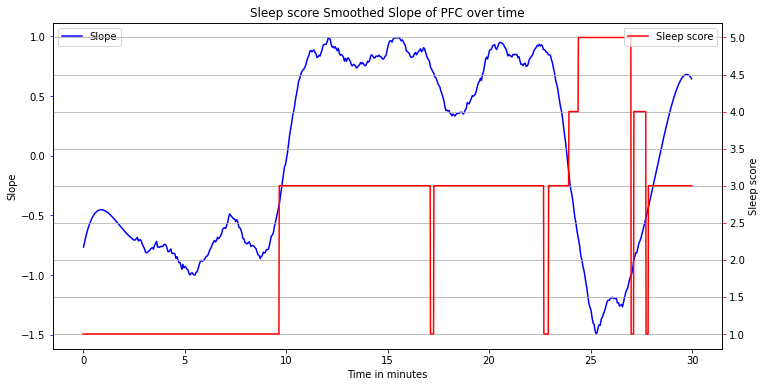

In [118]:
# plot the sleep scores over the smoothed pfc slope
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(time_minutes, pfc_slopes_smooth, color='blue', label='Slope')
ax1.set_xlabel('Time in minutes')
ax1.set_ylabel('Slope')
ax1.tick_params(axis='y', color='blue')
ax1.legend(['Slope'], loc='upper left')
ax2 = ax1.twinx()
ax2.plot(sleep_time, sleep_scoring_30_min, color='red', label='Sleep score')
ax2.set_ylabel('Sleep score')
ax2.tick_params(axis='y', color='red')
ax2.legend(['Sleep score'], loc='upper right')
plt.title('Sleep score Smoothed Slope of PFC over time')
plt.grid(True)
plt.show()

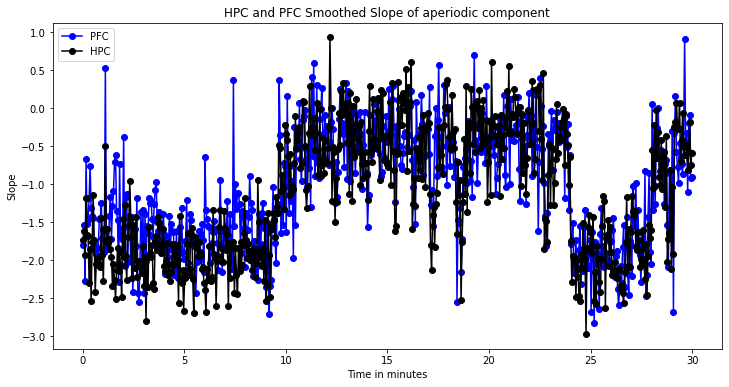

In [127]:
# plot the smooth pfc slope and the smooth hpc slope
plt.figure(figsize=(12, 6))
plt.plot(time_minutes, pfc_slopes, marker='o', color='blue')
plt.plot(time_minutes, slopes, marker='o',color='black')
plt.title('HPC and PFC Smoothed Slope of aperiodic component')
plt.xlabel('Time in minutes')
plt.ylabel('Slope')
plt.legend(['PFC', 'HPC'], loc='upper left')
plt.show()